## Описание проекта
  Федеральный оператора сотовой связи «Мегалайн» предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. У нас в распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
#### Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей

#### Правила округления и расчёта объёмов услуг
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.



#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
from scipy import stats as st

###  1. Исходные данные


In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Открываю все таблички и смотрю, насколько соответствут форматы данных содержимому параметров.

In [3]:
set_names_all = [calls, internet, messages, tariffs, users] # перечень таблиц
names_dict = {'calls' : calls , 'internet' : internet , 'messages' : messages , 'tariffs' : tariffs , 'users' : users }

In [4]:

    
    
def info_sample_df(name_df, df):
    if len(df) >= 5:
        len_sample = 5
    else:
        len_sample = len(df)
    print(f'{name_df} df info')
    print()
    df.info()
    print('-'*55)
    print()

    print(f'{name_df} df display')
    print()
    display(df.sample(len_sample))
    print('-'*55)
    print()



In [5]:
for name_df in names_dict:
    info_sample_df(name_df, names_dict[name_df])

calls df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
-------------------------------------------------------

calls df display



,id,call_date,duration,user_id
138452,1353_231,2018-05-11,3.05,1353
142295,1360_738,2018-08-19,0.00,1360
73109,1184_83,2018-12-27,3.42,1184
126643,1325_24,2018-09-21,1.60,1325
43210,1109_185,2018-07-12,0.00,1109


-------------------------------------------------------

internet df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
-------------------------------------------------------

internet df display



,Unnamed: 0,id,mb_used,session_date,user_id
125336,125336,1421_521,281.64,2018-03-08,1421
61263,61263,1208_101,197.89,2018-03-30,1208
78394,78394,1264_13,106.87,2018-11-19,1264
100388,100388,1337_425,629.38,2018-11-01,1337
2304,2304,1007_428,0.00,2018-08-18,1007


-------------------------------------------------------

messages df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
-------------------------------------------------------

messages df display



,id,message_date,user_id
84038,1350_182,2018-12-06,1350
26976,1113_135,2018-03-05,1113
5276,1021_432,2018-12-26,1021
33755,1146_553,2018-08-21,1146
73914,1311_323,2018-10-24,1311


-------------------------------------------------------

tariffs df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
-------------------------------------------------------

tariffs df display



,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


-------------------------------------------------------

users df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
-------------------------------------------------------

users df display



,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
216,1216,74,NaN,Волгоград,Рустам,Малинин,2018-11-23,smart
338,1338,64,NaN,Москва,Павел,Орлов,2018-05-11,smart
150,1150,58,NaN,Сургут,Майя,Муравьева,2018-08-05,ultra
422,1422,60,2018-12-21,Москва,Клара,Устинова,2018-10-12,smart
27,1027,62,NaN,Петрозаводск,Владислав,Авдеев,2018-04-10,smart


-------------------------------------------------------



Из обзора видно, что уникальные номера звонков, сообщений и траффика составные - первая часть содержит идентификатор пользователя, вторая - номер операции для этого пользователя. Попозже разберёмся, надо ли приводить это к исловому значению, или можно будет оставить так.

Чтоб лучше автоматизировать анализ информации, дату переведём везде в формат datetime.

В таблице internet есть столбец с номерами строк. Нам пока это не важно.

Видим много пропусков в таблице users в графе churn_date. Нам известно, что в этом столбце записана дата окончания действия тарифа. При передаче таблицы также нам сообщили, что пустые значения говорят о том, что пользователь всё ещё обслуживается по тарифу на момент выгрузки данных.



Рассмотрим данные в каждой колонке пристальней. Для этого упорядоченно отобразим уникальные значения и оценим их. 

In [6]:
# Функция перебирает все колонки таблицы и показывает упорядоченные уникальные значения.  
    
def unique_in_set(ds_name):
    x = ds_name.columns
    display('Dataset ', ds_name)
    print('Lines in dataset:', len(ds_name))
    print()
    for i in x:
        print(i, ds_name[i].nunique(), 'unique elements:')
        print()
        print(ds_name[i].sort_values().unique())
        print()



In [7]:
for name in names_dict:
    unique_in_set(names_dict[name])

'Dataset '

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Lines in dataset: 202607

id 202607 unique elements:

['1000_0' '1000_1' '1000_10' ... '1499_97' '1499_98' '1499_99']

call_date 365 unique elements:

['2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05'
 '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10'
 '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15'
 '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20'
 '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25'
 '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30'
 '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04'
 '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09'
 '2018-02-10' '2018-02-11' '2018-02-12' '2018-02-13' '2018-02-14'
 '2018-02-15' '2018-02-16' '2018-02-17' '2018-02-18' '2018-02-19'
 '2018-02-20' '2018-02-21' '2018-02-22' '2018-02-23' '2018-02-24'
 '2018-02-25' '2018-02-26' '2018-02-27' '2018-02-28' '2018-03-01'
 '2018-03-02' '2018-03-03' '2018-03-04' '2018-03-05' '201

'Dataset '

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


Lines in dataset: 149396

Unnamed: 0 149396 unique elements:

[     0      1      2 ... 149393 149394 149395]

id 149396 unique elements:

['1000_0' '1000_1' '1000_10' ... '1499_97' '1499_98' '1499_99']

mb_used 70003 unique elements:

[0.00000e+00 3.00000e-02 4.00000e-02 ... 1.65155e+03 1.70275e+03
 1.72483e+03]

session_date 365 unique elements:

['2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05'
 '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10'
 '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15'
 '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20'
 '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25'
 '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30'
 '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04'
 '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09'
 '2018-02-10' '2018-02-11' '2018-02-12' '2018-02-13' '2018-02-14'
 '2018-02-15' '2018-02-16' '2018-02-17' '2018-02-18' '2

'Dataset '

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


Lines in dataset: 123036

id 123036 unique elements:

['1000_0' '1000_1' '1000_10' ... '1499_97' '1499_98' '1499_99']

message_date 364 unique elements:

['2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05' '2018-01-06'
 '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10' '2018-01-11'
 '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15' '2018-01-16'
 '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20' '2018-01-21'
 '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25' '2018-01-26'
 '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30' '2018-01-31'
 '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04' '2018-02-05'
 '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09' '2018-02-10'
 '2018-02-11' '2018-02-12' '2018-02-13' '2018-02-14' '2018-02-15'
 '2018-02-16' '2018-02-17' '2018-02-18' '2018-02-19' '2018-02-20'
 '2018-02-21' '2018-02-22' '2018-02-23' '2018-02-24' '2018-02-25'
 '2018-02-26' '2018-02-27' '2018-02-28' '2018-03-01' '2018-03-02'
 '2018-03-03' '2018-03-04' '2018-03-05' '2018-03-06' '

'Dataset '

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Lines in dataset: 2

messages_included 2 unique elements:

[  50 1000]

mb_per_month_included 2 unique elements:

[15360 30720]

minutes_included 2 unique elements:

[ 500 3000]

rub_monthly_fee 2 unique elements:

[ 550 1950]

rub_per_gb 2 unique elements:

[150 200]

rub_per_message 2 unique elements:

[1 3]

rub_per_minute 2 unique elements:

[1 3]

tariff_name 2 unique elements:

['smart' 'ultra']



'Dataset '

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Lines in dataset: 500

user_id 500 unique elements:

[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 118

Подозрительных элементов будто и нет.

### 2. Подготовка данных

    

#### Задание: Приведите данные к нужным типам;
    

Из имеющихся данных в неудобном формате дата. 

In [8]:
set_names = [calls, internet, messages, users, users] # перечень таблиц, в которых меняю формат даты
set_columns = ['call_date', 'session_date', 'message_date', 'reg_date', 'churn_date'] # перечень столбцов для таблиц.


In [9]:
def change_date(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d').dt.date
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

In [10]:
for i in range(len(set_names)):
    change_date(set_names[i], set_columns[i])

In [11]:
for name_df in names_dict:
    info_sample_df(name_df, names_dict[name_df])

calls df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
-------------------------------------------------------

calls df display



,id,call_date,duration,user_id
31025,1078_369,2018-08-03,23.54,1078
8365,1021_833,2018-07-17,0.00,1021
77860,1196_92,2018-12-04,19.76,1196
159092,1393_344,2018-08-02,13.03,1393
188439,1465_156,2018-08-08,1.77,1465


-------------------------------------------------------

internet df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB
-------------------------------------------------------

internet df display



,Unnamed: 0,id,mb_used,session_date,user_id
10753,10753,1036_183,108.82,2018-10-28,1036
101394,101394,1340_105,546.21,2018-02-13,1340
8567,8567,1030_36,762.00,2018-12-25,1030
39073,39073,1135_553,80.75,2018-12-02,1135
118955,118955,1401_376,546.42,2018-05-14,1401


-------------------------------------------------------

messages df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
-------------------------------------------------------

messages df display



,id,message_date,user_id
23204,1096_484,2018-05-09,1096
116271,1472_575,2018-10-04,1472
70845,1300_597,2018-12-30,1300
2258,1005_120,2018-06-26,1005
24506,1100_263,2018-07-03,1100


-------------------------------------------------------

tariffs df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
-------------------------------------------------------

tariffs df display



,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


-------------------------------------------------------

users df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
-------------------------------------------------------

users df display



,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
92,1092,73,NaT,Ижевск,Вениамин,Амельченко,2018-06-19,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
71,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart
31,1031,66,NaT,Москва,Лаврентий,Тимофеев,2018-11-02,smart


-------------------------------------------------------



Получилось.

#### Задание: Найдите и исправьте ошибки в данных, если они есть.

Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.


Я затрудняюсь что-либо говорить об ошибках, я их просто не вижу на данном этапе.


#### Задание: Посчитать для каждого пользователя:

   ##### 1 количество сделанных звонков и израсходованных минут разговора по месяцам;
    

Чтоб правильно посчитать расходы по тарифу, надо округлить продолжительность звонков в большую сторону.

In [12]:

calls['round_duration'] = calls['duration'].apply(math.ceil) #round_duration

In [13]:
calls_count = calls.pivot_table(index='user_id', columns=pd.DatetimeIndex(calls['call_date']).month , values='id', aggfunc='count')
calls_sum = calls.pivot_table(index='user_id', columns=pd.DatetimeIndex(calls['call_date']).month , values='round_duration', aggfunc='sum')
calls_count.sample(5)

call_date,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1440,NaN,NaN,NaN,NaN,5.0,37.0,21.0,35.0,28.0,28.0,27.0,27.0
1120,5.0,27.0,44.0,35.0,40.0,49.0,38.0,48.0,35.0,49.0,36.0,38.0
1476,NaN,NaN,NaN,NaN,71.0,62.0,65.0,59.0,72.0,68.0,71.0,81.0
1112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,78.0,69.0,75.0
1295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,28.0,35.0,43.0


In [14]:
calls_sum.sample(5)

call_date,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,686.0,784.0
1352,NaN,NaN,NaN,412.0,780.0,805.0,827.0,796.0,743.0,816.0,881.0,706.0
1079,NaN,NaN,NaN,NaN,162.0,607.0,592.0,653.0,603.0,345.0,560.0,578.0
1385,270.0,277.0,310.0,348.0,343.0,356.0,383.0,326.0,374.0,368.0,273.0,333.0
1184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,323.0,319.0,265.0,278.0


In [15]:

calls_sum['start_call'] = calls.groupby('user_id')['call_date'].min()
calls_sum['end_call'] = calls.groupby('user_id')['call_date'].max()


calls_sum.sample(5)

# Добавляю колонки с датами первого звонка и последнего из предоставленного объёма.
# Они должны лежать внутри диапазона значений из таблицы про пользователей.

call_date,1,2,3,4,5,6,7,8,9,10,11,12,start_call,end_call
user_id,,,,,,,,,,,,,,
1184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,323.0,319.0,265.0,278.0,2018-09-03,2018-12-31
1032,380.0,371.0,487.0,521.0,512.0,402.0,415.0,446.0,507.0,385.0,410.0,482.0,2018-01-04,2018-12-31
1422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,412.0,277.0,2018-10-12,2018-12-20
1347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1129.0,1208.0,2018-11-01,2018-12-31
1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,734.0,2018-11-28,2018-12-30


In [16]:

money = users.copy([])
money.columns
# Чтоб потом соединить с табличкой тарифов, изменяю название колонки с тарифами.

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

In [17]:
money.columns = ['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name']

In [18]:
money = money.merge(calls_sum, on='user_id', how='left')
money.sample(5)  # Объединяю с таблицей о звонках.

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,1,2,...,5,6,7,8,9,10,11,12,start_call,end_call
202,1202,22,NaT,Владивосток,Адам,Адаменко,2018-09-20,smart,NaN,NaN,...,NaN,NaN,NaN,NaN,75.0,363.0,378.0,287.0,2018-09-20,2018-12-31
409,1409,42,NaT,Набережные Челны,Даниил,Алиев,2018-03-14,smart,NaN,NaN,...,734.0,635.0,643.0,846.0,733.0,655.0,750.0,667.0,2018-03-14,2018-12-31
262,1262,21,NaT,Ульяновск,Антонина,Ларина,2018-03-17,smart,NaN,NaN,...,419.0,329.0,454.0,381.0,362.0,309.0,433.0,472.0,2018-03-17,2018-12-31
152,1152,44,NaT,Мурманск,Марина,Щербакова,2018-02-05,ultra,NaN,172.0,...,345.0,291.0,294.0,239.0,288.0,243.0,421.0,415.0,2018-02-05,2018-12-31
408,1408,53,NaT,Самара,Касьян,Кукушкин,2018-05-27,smart,NaN,NaN,...,95.0,597.0,525.0,549.0,750.0,624.0,614.0,541.0,2018-05-27,2018-12-31


Оставлю в ней только два столбца от информации о пользователях - user_id, 'city' и tariff.

In [19]:
money = money.drop(['age', 'first_name', 'last_name'], axis=1)
money.columns

Index([    'user_id',  'churn_date',        'city',    'reg_date',
       'tariff_name',             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,            11,
                  12,  'start_call',    'end_call'],
      dtype='object')

   ##### 2 количество отправленных сообщений по месяцам;
   
Проделываю то же самое с сообщениями - просчёт ежемесячного использования и объединение с таблицей для рассчёта стоимости.

In [20]:
messages_count = messages.pivot_table(index = 'user_id', columns=pd.DatetimeIndex(messages['message_date']).month , values = 'id', aggfunc = 'count')
messages_count['start_mes']=messages.groupby('user_id')['message_date'].min()
messages_count['end_mes'] = messages.groupby('user_id')['message_date'].max()
messages_count.sample(5)

message_date,1,2,3,4,5,6,7,8,9,10,11,12,start_mes,end_mes
user_id,,,,,,,,,,,,,,
1020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,24.0,9.0,2018-10-23,2018-12-11
1058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,27.0,29.0,2018-10-08,2018-12-29
1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,55.0,86.0,60.0,2018-09-10,2018-12-31
1468,NaN,5.0,13.0,9.0,11.0,5.0,9.0,18.0,13.0,14.0,13.0,11.0,2018-02-14,2018-12-30
1103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,2018-12-05,2018-12-31


In [21]:
money = money.merge(messages_count, on='user_id', how='left')
money.info()

# При объединении таблиц у колонок с одинаковыми названиями появляются суффикы. 
# Просто запомним, что x - это звонки, у - это сообщения.
# Без индекса будет траффик.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      500 non-null    int64         
 1   churn_date   38 non-null     datetime64[ns]
 2   city         500 non-null    object        
 3   reg_date     500 non-null    datetime64[ns]
 4   tariff_name  500 non-null    object        
 5   1_x          43 non-null     float64       
 6   2_x          82 non-null     float64       
 7   3_x          114 non-null    float64       
 8   4_x          165 non-null    float64       
 9   5_x          205 non-null    float64       
 10  6_x          244 non-null    float64       
 11  7_x          289 non-null    float64       
 12  8_x          337 non-null    float64       
 13  9_x          370 non-null    float64       
 14  10_x         411 non-null    float64       
 15  11_x         444 non-null    float64       
 16  12_x    

   ##### 3 объем израсходованного интернет-трафика по месяцам;
   

In [22]:
internet_sum = internet.pivot_table(index = 'user_id', columns=pd.DatetimeIndex(internet['session_date']).month , values = 'mb_used', aggfunc = 'sum')
internet_sum['start_session'] = internet.groupby('user_id')['session_date'].min()
internet_sum['end_session'] = internet.groupby('user_id')['session_date'].max()

internet_sum.sample(5)

session_date,1,2,3,4,5,6,7,8,9,10,11,12,start_session,end_session
user_id,,,,,,,,,,,,,,
1233,NaN,NaN,NaN,NaN,8557.62,26253.76,21522.33,20460.8,21250.98,27935.31,20566.12,20315.25,2018-05-24,2018-12-31
1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7331.49,16025.90,26094.93,2018-10-18,2018-12-31
1235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13424.18,15602.29,16562.91,2018-10-06,2018-12-29
1184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11506.59,16462.90,10450.45,9121.62,2018-09-04,2018-12-31
1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1844.50,32503.56,32650.91,2018-10-30,2018-12-31


In [23]:
money = money.merge(internet_sum, on='user_id', how='left')
money.columns

Index([      'user_id',    'churn_date',          'city',      'reg_date',
         'tariff_name',           '1_x',           '2_x',           '3_x',
                 '4_x',           '5_x',           '6_x',           '7_x',
                 '8_x',           '9_x',          '10_x',          '11_x',
                '12_x',    'start_call',      'end_call',           '1_y',
                 '2_y',           '3_y',           '4_y',           '5_y',
                 '6_y',           '7_y',           '8_y',           '9_y',
                '10_y',          '11_y',          '12_y',     'start_mes',
             'end_mes',               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              11,
                    12, 'start_session',   'end_session'],
      dtype='object')

Есть ли строки, в которых дата регистрации позже, чем первый звонок/сообщение/интернет-сессия?

In [24]:
money.loc[(money['reg_date'] > money['start_call']) | (money['reg_date'] > money['start_mes']) | (money['reg_date'] > money['start_session']) ]

,user_id,churn_date,city,reg_date,tariff_name,1_x,2_x,3_x,4_x,5_x,...,5,6,7,8,9,10,11,12,start_session,end_session


Есть ли строки, в которых дата завершения пользования меньше, чем ппоследний звонок/сообщение/интернет-сессия?

In [25]:
money.loc[(money['churn_date'] < money['end_call']) | (money['churn_date'] < money['end_mes']) | (money['churn_date'] < money['end_session']) ]

,user_id,churn_date,city,reg_date,tariff_name,1_x,2_x,3_x,4_x,5_x,...,5,6,7,8,9,10,11,12,start_session,end_session


Все даты использования связи находятся в диапазоне действия договора.

   ##### 4 помесячную выручку с каждого пользователя 
   (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [26]:
# Чтоб производить все вычисления в одном месте, объединяю две таблицы - с пользователями и тарифами.

money = money.merge(tariffs, on='tariff_name', how='left')

In [27]:
money.sample(5) # Теперь таблица для вычислений выглядит так:

,user_id,churn_date,city,reg_date,tariff_name,1_x,2_x,3_x,4_x,5_x,...,12,start_session,end_session,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
355,1355,2018-11-27,Киров,2018-07-21,smart,NaN,NaN,NaN,NaN,NaN,...,NaN,2018-07-24,2018-11-25,50,15360,500,550,200,3,3
279,1279,NaT,Омск,2018-08-13,smart,NaN,NaN,NaN,NaN,NaN,...,11372.25,2018-08-13,2018-12-31,50,15360,500,550,200,3,3
437,1437,NaT,Казань,2018-08-03,smart,NaN,NaN,NaN,NaN,NaN,...,22846.46,2018-08-03,2018-12-31,50,15360,500,550,200,3,3
107,1107,NaT,Орёл,2018-07-20,smart,NaN,NaN,NaN,NaN,NaN,...,18611.33,2018-07-20,2018-12-31,50,15360,500,550,200,3,3
47,1047,NaT,Саратов,2018-10-29,smart,NaN,NaN,NaN,NaN,NaN,...,27387.09,2018-10-29,2018-12-31,50,15360,500,550,200,3,3


In [28]:
money.columns

Index([              'user_id',            'churn_date',
                        'city',              'reg_date',
                 'tariff_name',                   '1_x',
                         '2_x',                   '3_x',
                         '4_x',                   '5_x',
                         '6_x',                   '7_x',
                         '8_x',                   '9_x',
                        '10_x',                  '11_x',
                        '12_x',            'start_call',
                    'end_call',                   '1_y',
                         '2_y',                   '3_y',
                         '4_y',                   '5_y',
                         '6_y',                   '7_y',
                         '8_y',                   '9_y',
                        '10_y',                  '11_y',
                        '12_y',             'start_mes',
                     'end_mes',                       1,
                             2,

In [29]:
# Создаю списки, по которым буду ориентироваться при вычислении.


colums_calls = [               '1_x',                   '2_x',
                         '3_x',                   '4_x',
                         '5_x',                   '6_x',
                         '7_x',                   '8_x',
                         '9_x',                  '10_x',
                        '11_x',                  '12_x']
colums_mes = [
                         '1_y',                   '2_y',
                         '3_y',                   '4_y',
                         '5_y',                   '6_y',
                         '7_y',                   '8_y',
                         '9_y',                  '10_y',
                        '11_y',                  '12_y']

colums_internet = [          1,                       2,
                             3,                       4,
                             5,                       6,
                             7,                       8,
                             9,                      10,
                            11,                      12]

colums_else = [           'messages_included', 'mb_per_month_included',
            'minutes_included',       'rub_monthly_fee',
                  'rub_per_gb',       'rub_per_message',
              'rub_per_minute']




def line_funk(line):
    cost_ = []  #=0
    for ind in range(len(colums_calls)):
        fee = 0
        cost_m = 0
        
        if line[colums_calls[ind]] >= 0:
            fee = 1
            if line[colums_calls[ind]] > line['minutes_included']:
                cost_m += (line[colums_calls[ind]] - line['minutes_included'])*line['rub_per_minute']
                
        if line[colums_mes[ind]] >= 0:
            fee = 1
            if line[colums_mes[ind]] > line['messages_included']:
                cost_m += (line[colums_mes[ind]] - line['messages_included'])*line['rub_per_message']
        
        if line[colums_internet[ind]] >= 0:
            fee = 1
            if line[colums_internet[ind]] > line['mb_per_month_included']:  # Стоимость указана за гигабайт, а расход в мегабайтах
                cost_m += (math.ceil((line[colums_internet[ind]] - line['mb_per_month_included'])/1024))*line['rub_per_gb']

        cost_.append(cost_m + fee*line['rub_monthly_fee'])

    return cost_


In [30]:
# Применяю фуункцию к каждой строке таблицы.

money['cost'] = money.apply(lambda row : line_funk(row), axis=1) 

In [31]:
money.sample(5) # Вот, что получилось.

,user_id,churn_date,city,reg_date,tariff_name,1_x,2_x,3_x,4_x,5_x,...,start_session,end_session,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,cost
264,1264,NaT,Хабаровск,2018-04-22,smart,NaN,NaN,NaN,95.0,341.0,...,2018-04-22,2018-12-31,50,15360,500,550,200,3,3,"[0, 0, 0, 550, 1150, 550, 2150, 2350, 750, 115..."
30,1030,NaT,Махачкала,2018-05-23,smart,NaN,NaN,NaN,NaN,109.0,...,2018-05-23,2018-12-31,50,15360,500,550,200,3,3,"[0, 0, 0, 0, 550, 718.0, 703.0, 691.0, 679.0, ..."
218,1218,NaT,Екатеринбург,2018-07-14,smart,NaN,NaN,NaN,NaN,NaN,...,2018-07-14,2018-12-31,50,15360,500,550,200,3,3,"[0, 0, 0, 0, 0, 0, 550, 550, 901.0, 550, 550, ..."
0,1000,NaT,Краснодар,2018-05-25,ultra,NaN,NaN,NaN,NaN,159.0,...,2018-05-26,2018-12-30,1000,30720,3000,1950,150,1,1,"[0, 0, 0, 0, 1950, 1950, 1950, 1950, 1950, 195..."
238,1238,NaT,Ростов-на-Дону,2018-01-08,smart,55.0,55.0,167.0,57.0,127.0,...,2018-01-08,2018-12-31,50,15360,500,550,200,3,3,"[550, 550, 1350, 550, 550, 550, 1150, 550, 950..."


Теперь последний столбец надо преобразовать в таблицу и объединить его с таблицей, в которой от этой вычислительной оставим только полььзователей и тарифы.

In [32]:
user_pay_per_month = money.copy()

In [33]:
user_pay_per_month.columns

Index([              'user_id',            'churn_date',
                        'city',              'reg_date',
                 'tariff_name',                   '1_x',
                         '2_x',                   '3_x',
                         '4_x',                   '5_x',
                         '6_x',                   '7_x',
                         '8_x',                   '9_x',
                        '10_x',                  '11_x',
                        '12_x',            'start_call',
                    'end_call',                   '1_y',
                         '2_y',                   '3_y',
                         '4_y',                   '5_y',
                         '6_y',                   '7_y',
                         '8_y',                   '9_y',
                        '10_y',                  '11_y',
                        '12_y',             'start_mes',
                     'end_mes',                       1,
                             2,

In [34]:
user_pay_per_month = user_pay_per_month.drop(['churn_date',
                    'reg_date',
                         '1_x',                   '2_x',
                         '3_x',                   '4_x',
                         '5_x',                   '6_x',
                         '7_x',                   '8_x',
                         '9_x',                  '10_x',
                        '11_x',                  '12_x',
                  'start_call',              'end_call',
                         '1_y',                   '2_y',
                         '3_y',                   '4_y',
                         '5_y',                   '6_y',
                         '7_y',                   '8_y',
                         '9_y',                  '10_y',
                        '11_y',                  '12_y',
                   'start_mes',               'end_mes',
                             1,                       2,
                             3,                       4,
                             5,                       6,
                             7,                       8,
                             9,                      10,
                            11,                      12,
               'start_session',           'end_session',
           'messages_included', 'mb_per_month_included',
            'minutes_included',       'rub_monthly_fee',
                  'rub_per_gb',       'rub_per_message',
              'rub_per_minute'], axis=1)

In [35]:
user_pay_per_month.sample(5)

,user_id,city,tariff_name,cost
448,1448,Кострома,smart,"[0, 0, 0, 0, 0, 0, 0, 0, 550, 550, 1828.0, 1550]"
455,1455,Балашиха,ultra,"[0, 0, 1950, 1950, 1950, 1950, 1950, 1950, 195..."
387,1387,Краснодар,smart,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2055.0]"
33,1033,Москва,smart,"[0, 0, 0, 0, 0, 0, 550, 2031.0, 2831.0, 1640.0..."
276,1276,Москва,ultra,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2400, 1950, 1950]"


In [36]:
dftmp = user_pay_per_month.cost.apply(pd.Series)


In [37]:
dftmp.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']

In [38]:
dftmp.sample(5)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2945.0,1733.0,1083.0
226,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,3584.0,3985.0
374,0.0,0.0,0.0,1381.0,1208.0,1401.0,1771.0,1023.0,619.0,2191.0,1219.0,1798.0


In [39]:
user_pay_per_month = user_pay_per_month.merge(dftmp, left_index=True, right_index=True)

In [40]:
user_pay_per_month = user_pay_per_month.drop('cost', axis=1)

In [41]:
user_pay_per_month.sample(5)


,user_id,city,tariff_name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec
309,1309,Казань,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0
76,1076,Уфа,smart,0.0,0.0,819.0,840.0,2106.0,1858.0,3211.0,1975.0,1724.0,2182.0,802.0,2014.0
338,1338,Москва,smart,0.0,0.0,0.0,0.0,550.0,950.0,2150.0,950.0,1350.0,950.0,550.0,1150.0
448,1448,Кострома,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,1828.0,1550.0
458,1458,Барнаул,ultra,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0


### 3. Анализ данных

Задание:
#### Опишите поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Для этого задания будем работать с таблицами для каждого вида взаимодействия отдельно. Это calls_sum, messages_count и internet_sum.

In [42]:
calls_sum.sample(5)

call_date,1,2,3,4,5,6,7,8,9,10,11,12,start_call,end_call
user_id,,,,,,,,,,,,,,
1142,NaN,NaN,81.0,475.0,468.0,503.0,515.0,354.0,465.0,457.0,478.0,437.0,2018-03-24,2018-12-31
1145,NaN,NaN,NaN,348.0,508.0,397.0,520.0,523.0,454.0,497.0,367.0,524.0,2018-04-11,2018-12-31
1476,NaN,NaN,NaN,NaN,459.0,491.0,492.0,456.0,622.0,540.0,556.0,588.0,2018-05-01,2018-12-31
1431,NaN,NaN,89.0,266.0,163.0,318.0,299.0,196.0,214.0,358.0,278.0,265.0,2018-03-18,2018-12-31
1177,NaN,NaN,NaN,NaN,NaN,126.0,454.0,415.0,409.0,479.0,341.0,570.0,2018-06-19,2018-12-31


In [43]:
calls_sum = calls_sum.merge(user_pay_per_month, on='user_id')

In [44]:
calls_sum = calls_sum.drop(['city', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec', 'start_call', 'end_call'], axis=1)

In [45]:
calls_sum.sample(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name
203,1206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.0,106.0,smart
36,1036,NaN,NaN,NaN,NaN,NaN,NaN,285.0,554.0,430.0,530.0,424.0,669.0,smart
244,1248,NaN,NaN,NaN,NaN,105.0,875.0,740.0,667.0,726.0,727.0,636.0,808.0,smart
315,1319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.0,729.0,1005.0,706.0,868.0,smart
160,1163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,395.0,231.0,smart


In [46]:
print('Среднее по звонкам по месяцам для каждого тарифа в минутах.')

tariff_in_months = pd.pivot_table(calls_sum, index='tariff_name', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
tariff_in_months

Среднее по звонкам по месяцам для каждого тарифа в минутах.


,1,2,3,4,5,6,7,8,9,10,11,12
tariff_name,,,,,,,,,,,,
smart,203.852941,298.689655,390.051948,367.133929,387.361702,398.067485,408.353234,423.269231,430.266409,427.590444,436.647619,479.985119
ultra,428.111111,297.125000,489.648649,475.301887,534.250000,497.469136,564.397727,530.611650,558.882883,581.728814,562.364341,614.925373


<AxesSubplot:>

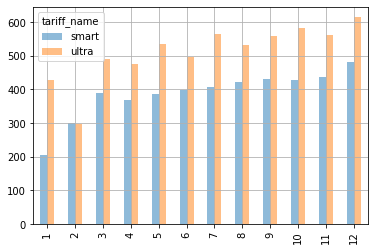

In [47]:
mean_calls = tariff_in_months.T # Транспонирую таблицу, чтоб построить годовой график для каждого тарифа. Не нашла пока, как строить по строкам.
mean_calls.plot(grid=True, kind='bar', alpha=0.5)

In [48]:
        
var_calls = np.var(mean_calls['smart'], ddof=1)
std_calls = np.std(mean_calls['smart'], ddof=1)

print(f'Для тарифа smart для звонков стандартное отклонение равно {std_calls:.4}, дисперсия равна {var_calls:.6},\nсреднее равно {mean_calls["smart"].mean():.5}, медиана равна {mean_calls["smart"].median():.5}')

var_calls = np.var(mean_calls['ultra'], ddof=1)
std_calls = np.std(mean_calls['ultra'], ddof=1)

print(f'Для тарифа ultra для звонков стандартное отклонение равно {std_calls:.4}, дисперсия равна {var_calls:.6},\nсреднее равно {mean_calls["ultra"].mean():.5}, медиана равна {mean_calls["ultra"].median():.5}')

Для тарифа smart для звонков стандартное отклонение равно 72.78, дисперсия равна 5296.9,
среднее равно 387.61, медиана равна 403.21
Для тарифа ultra для звонков стандартное отклонение равно 84.77, дисперсия равна 7185.12,
среднее равно 511.23, медиана равна 532.43


<AxesSubplot:ylabel='Frequency'>

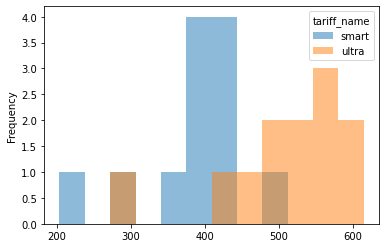

In [49]:
mean_calls.plot(kind='hist', bins=12, alpha=0.5)

'ultra' скошено влево сильнее, чем 'smart', больше похоже на нормальное распределение.

In [50]:
messages_count.sample(5)

message_date,1,2,3,4,5,6,7,8,9,10,11,12,start_mes,end_mes
user_id,,,,,,,,,,,,,,
1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,29.0,23.0,2018-10-10,2018-12-31
1058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,27.0,29.0,2018-10-08,2018-12-29
1097,NaN,NaN,NaN,NaN,NaN,9.0,31.0,28.0,29.0,38.0,28.0,33.0,2018-06-25,2018-12-31
1480,NaN,8.0,19.0,20.0,26.0,18.0,31.0,20.0,19.0,NaN,NaN,NaN,2018-02-14,2018-09-25
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,2018-01-25,2018-12-31


In [51]:
messages_count = messages_count.merge(user_pay_per_month, on='user_id')
messages_count = messages_count.drop(['city', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec', 'start_mes', 'end_mes'], axis=1)

In [52]:
print('Среднее по сообщениям по месяцам для каждого тарифа в штуках.')

mes_in_months = pd.pivot_table(messages_count, index='tariff_name', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
mes_in_months

Среднее по сообщениям по месяцам для каждого тарифа в штуках.


,1,2,3,4,5,6,7,8,9,10,11,12
tariff_name,,,,,,,,,,,,
smart,20.000000,27.9400,35.550725,35.864583,39.032787,38.577465,38.988506,38.750000,39.219731,39.082677,39.881481,42.264808
ultra,43.428571,32.9375,47.800000,44.512821,48.769231,52.313433,62.136986,58.897727,63.294737,69.776699,66.159292,72.008547


<AxesSubplot:>

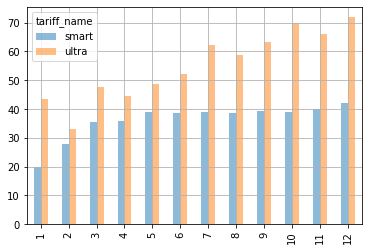

In [53]:
mean_mes = mes_in_months.T 
mean_mes.plot(grid=True, kind='bar', alpha=0.5)

In [54]:
        
var_calls = np.var(mean_mes['smart'], ddof=1)
std_calls = np.std(mean_mes['smart'], ddof=1)

print(f'Для тарифа smart для звонков стандартное отклонение равно {std_calls:.4}, дисперсия равна {var_calls:.4},\nсреднее равно {mean_mes["smart"].mean():.4}, медиана равна {mean_mes["smart"].median():.4}')

var_calls = np.var(mean_mes['ultra'], ddof=1)
std_calls = np.std(mean_mes['ultra'], ddof=1)

print(f'Для тарифа ultra для звонков стандартное отклонение равно {std_calls:.4}, дисперсия равна {var_calls:.5},\nсреднее равно {mean_mes["ultra"].mean():.5}, медиана равна {mean_mes["ultra"].median():.4}')

Для тарифа smart для звонков стандартное отклонение равно 6.23, дисперсия равна 38.81,
среднее равно 36.26, медиана равна 38.87
Для тарифа ultra для звонков стандартное отклонение равно 12.04, дисперсия равна 145.02,
среднее равно 55.17, медиана равна 55.61


<AxesSubplot:ylabel='Frequency'>

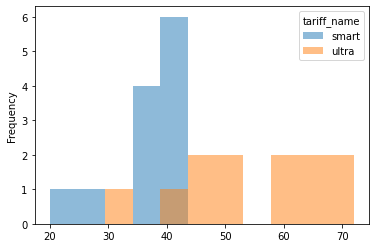

In [55]:
mean_mes.plot(kind='hist', bins=11, alpha=0.5)

'ultra' довольно плоское, 'smart' похоже на нормальное распределение, скошено влево.

In [56]:
internet_sum.sample(5)

session_date,1,2,3,4,5,6,7,8,9,10,11,12,start_session,end_session
user_id,,,,,,,,,,,,,,
1477,NaN,NaN,NaN,4293.98,19612.05,22456.27,22704.47,19956.72,18939.77,20499.78,27944.05,20606.69,2018-04-24,2018-12-31
1262,NaN,NaN,11191.18,17135.36,22709.91,16087.37,19477.04,20699.54,20837.20,19133.99,26240.78,18845.90,2018-03-17,2018-12-31
1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7331.49,16025.90,26094.93,2018-10-18,2018-12-31
1295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8246.62,19726.10,20710.62,16545.59,2018-09-19,2018-12-30
1476,NaN,NaN,NaN,530.78,21781.33,14623.29,15983.38,25106.38,18602.93,25125.69,14410.79,14121.34,2018-04-30,2018-12-30


In [57]:
internet_sum = internet_sum.merge(user_pay_per_month, on='user_id')
internet_sum = internet_sum.drop(['city', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec', 'start_session', 'end_session'], axis=1)
internet_sum.sample(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name
367,1369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10880.74,27432.23,23256.05,27705.13,22988.89,ultra
263,1264,NaN,NaN,NaN,4299.21,18220.49,13740.04,23383.31,24095.44,15890.58,18307.64,15823.26,16702.27,smart
146,1147,NaN,NaN,NaN,NaN,NaN,NaN,13066.93,20128.31,21672.02,22329.16,19898.06,23973.95,smart
23,1023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7023.24,16701.92,28380.99,smart
301,1303,NaN,NaN,NaN,NaN,NaN,NaN,2696.04,20939.05,28524.79,28987.38,18243.36,18349.97,ultra


In [58]:
print('Среднее по траффику по месяцам для каждого тарифа в мегабайтах.')

mb_in_months = pd.pivot_table(internet_sum, index='tariff_name', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
mb_in_months

Среднее по траффику по месяцам для каждого тарифа в мегабайтах.


,1,2,3,4,5,6,7,8,9,10,11,12
tariff_name,,,,,,,,,,,,
smart,8513.717647,11597.054310,15104.159091,13462.180625,15805.184326,15794.647988,15743.150348,16681.706068,16303.578808,16757.122891,16895.696646,18113.662047
ultra,13140.681111,12846.477273,17535.550270,16828.134364,19656.534091,19152.950602,20723.394778,19760.734434,19372.735702,20209.643361,19935.585489,21951.094130


<AxesSubplot:>

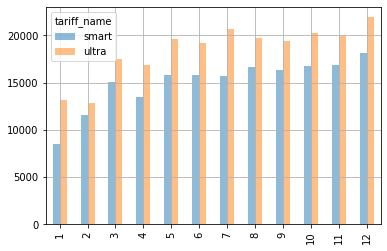

In [59]:
mean_mb = mb_in_months.T
mean_mb.plot(grid=True, kind='bar', alpha=0.5)

In [60]:
       
var_calls = np.var(mean_mb['smart'], ddof=1)
std_calls = np.std(mean_mb['smart'], ddof=1)

print(f'Для тарифа smart для интернета стандартное отклонение равно {std_calls:.6}, дисперсия равна {var_calls:.9},\nсреднее равно {mean_mb["smart"].mean():.7}, медиана равна {mean_mb["smart"].median():.7}')

var_calls = np.var(mean_mb['ultra'], ddof=1)
std_calls = np.std(mean_mb['ultra'], ddof=1)

print(f'Для тарифа ultra для интернета стандартное отклонение равно {std_calls:.6}, дисперсия равна {var_calls:.9},\nсреднее равно {mean_mb["ultra"].mean():.7}, медиана равна {mean_mb["ultra"].median():.7}')

Для тарифа smart для интернета стандартное отклонение равно 2675.03, дисперсия равна 7155776.26,
среднее равно 15064.32, медиана равна 15799.92
Для тарифа ultra для интернета стандартное отклонение равно 2865.1, дисперсия равна 8208798.54,
среднее равно 18426.13, медиана равна 19514.63


<AxesSubplot:ylabel='Frequency'>

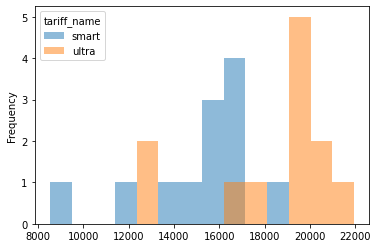

In [61]:
mean_mb.plot(kind='hist', bins=14, alpha=0.5)

Оба скошены влево.

In [62]:
tariff_user_pay_per_month = pd.pivot_table(user_pay_per_month, index='tariff_name', values=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec'])

In [63]:
print('Среднее по стоимости обслуживания по месяцам для каждого тарифа в рублях.')
tariff_user_pay_per_month

Среднее по стоимости обслуживания по месяцам для каждого тарифа в рублях.


,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Okt,Sep
tariff_name,,,,,,,,,,,,
smart,307.310541,884.159544,1515.569801,136.754986,69.871795,700.894587,562.561254,255.487179,481.051282,1209.125356,1143.210826,925.886040
ultra,738.926174,1495.973154,1995.302013,318.120805,117.785235,1293.624161,1149.664430,500.335570,926.174497,1881.543624,1705.369128,1562.416107


<AxesSubplot:>

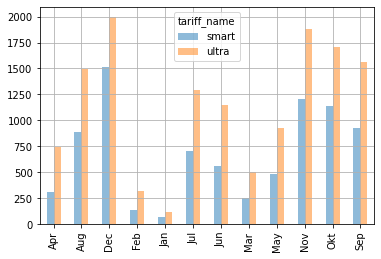

In [64]:
mean_tariff_user_pay_per_month = tariff_user_pay_per_month.T # Транспонирую таблицу
mean_tariff_user_pay_per_month.plot(grid=True, kind='bar', alpha=0.5)

In [65]:
       
var_calls = np.var(mean_tariff_user_pay_per_month['smart'], ddof=1)
std_calls = np.std(mean_tariff_user_pay_per_month['smart'], ddof=1)

print(f'для тарифа smart для стоимости стандартное отклонение равно {std_calls:.6}, дисперсия равна {var_calls:.9},\nсреднее равно {mean_tariff_user_pay_per_month["smart"].mean():.5}, медиана равна {mean_tariff_user_pay_per_month["smart"].median():.5}')

var_calls = np.var(mean_tariff_user_pay_per_month['ultra'], ddof=1)
std_calls = np.std(mean_tariff_user_pay_per_month['ultra'], ddof=1)

print(f'для тарифа ultra для стоимости стандартное отклонение равно {std_calls:.6}, дисперсия равна {var_calls:.9},\nсреднее равно {mean_tariff_user_pay_per_month["ultra"].mean():.5}, медиана равна {mean_tariff_user_pay_per_month["ultra"].median():.5}')

для тарифа smart для стоимости стандартное отклонение равно 460.737, дисперсия равна 212278.212,
среднее равно 682.66, медиана равна 631.73
для тарифа ultra для стоимости стандартное отклонение равно 622.756, дисперсия равна 387825.006,
среднее равно 1140.4, медиана равна 1221.6


<AxesSubplot:ylabel='Frequency'>

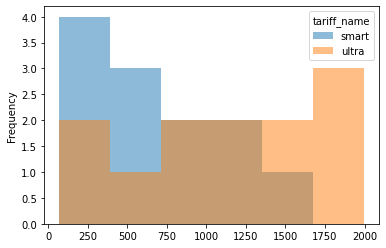

In [66]:
mean_tariff_user_pay_per_month.plot(kind='hist', bins=6, alpha=0.5)

На тарифе 'smart' больше маленьких сумм к оплате, чем больших, а на тарифе 'ultra' более равномерное распределение стоимости.

### 4. Проверка гипотез

   ###### Гипотеза 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Нулевая гипотеза - средняя выручка тарифов «Ультра» и «Смарт» одинаковые.
Альтернативная гипотеза - средняя выручка тарифов «Ультра» и «Смарт» различаются.

Можно ли так переворачивать задачу, не знаю, но именно под такую формулировку мы имеем метод, который проверяет гипотезу именно о равенстве средних двух генеральных совокупностей.

Возьму alpha = 0.01

Разделим весь объём данных на две совокупности, которые обозначены в гипотезе.

In [67]:
users_smart = user_pay_per_month[user_pay_per_month['tariff_name']=='smart']
users_ultra = user_pay_per_month[user_pay_per_month['tariff_name']=='ultra']

print('Пользователей на тарифе \'smart\'', len(users_smart))
print('Пользователей на тарифе \'ultra\'', len(users_ultra))

display(users_smart.sample(5))
users_ultra.sample(5)

Пользователей на тарифе 'smart' 351
Пользователей на тарифе 'ultra' 149


,user_id,city,tariff_name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec
478,1478,Грозный,smart,0.0,0.0,0.0,0.0,0.0,0.0,550.0,625.0,858.0,1416.0,1219.0,649.0
468,1468,Тамбов,smart,0.0,550.0,550.0,550.0,550.0,950.0,550.0,550.0,550.0,550.0,550.0,550.0
12,1012,Санкт-Петербург,smart,0.0,0.0,550.0,950.0,2750.0,2550.0,2150.0,1950.0,1350.0,3350.0,1950.0,550.0
191,1191,Набережные Челны,smart,0.0,0.0,0.0,0.0,0.0,550.0,2309.0,3315.0,1387.0,550.0,0.0,0.0
210,1210,Севастополь,smart,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2062.0,1890.0,2256.0,1313.0,1216.0


,user_id,city,tariff_name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec
150,1150,Сургут,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0
222,1222,Уфа,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0
379,1379,Москва,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,3450.0,1950.0
495,1495,Иркутск,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0
91,1091,Набережные Челны,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0


In [68]:
users_smart = users_smart.drop(['user_id', 'city', 'tariff_name'], axis=1)
users_ultra = users_ultra.drop(['user_id', 'city', 'tariff_name'], axis=1)

In [69]:
display(users_smart.sample(5))
users_ultra.sample(5)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec
214,0.0,0.0,0.0,0.0,0.0,0.0,553.0,562.0,577.0,631.0,598.0,595.0
321,0.0,750.0,550.0,550.0,1150.0,550.0,1550.0,1777.0,750.0,1150.0,1350.0,1150.0
383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,750.0,550.0
141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0
100,0.0,0.0,0.0,0.0,0.0,0.0,1246.0,1191.0,750.0,727.0,1040.0,823.0


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec
335,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
402,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,2100.0,1950.0,1950.0,1950.0,1950.0
452,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
403,0.0,0.0,0.0,0.0,1950.0,2100.0,3000.0,1950.0,1950.0,2250.0,2700.0,1950.0


Применим к ним гипотезу о равенстве средних двух генеральных совокупностей

In [70]:
st.ttest_ind(users_smart, users_ultra, equal_var=False)

Ttest_indResult(statistic=array([-1.18316455, -2.87684121, -3.12076364, -5.06528032, -4.65065378,
       -6.16971798, -5.94101385, -6.44860109, -7.51185396, -6.53502366,
       -8.84867108, -5.90871636]), pvalue=array([2.38254196e-01, 4.49535360e-03, 2.06371462e-03, 9.65184664e-07,
       5.81527831e-06, 3.18511557e-09, 1.08141701e-08, 5.64813663e-10,
       8.82524220e-13, 2.76332244e-10, 6.16187651e-17, 7.30251999e-09]))

Наверное, это не то, что нужно. Я получила статистики для каждого месяца отдельно, но это не то, что нужно.
Попробую взять табличку со средней стоимостью по месяцам и разбить её на два массива согласно тарифам. Там маловато цифр - по 12 в каждой подборке. 

In [71]:
mean_tariff_user_pay_per_month['smart'].median()

631.7279202279203

In [72]:
mean_tariff_user_pay_per_month['ultra'].median()

1221.6442953020132

Применим гипотезу о равенстве средних двух генеральных совокупностей следующим образом:

In [73]:
result = st.ttest_ind(mean_tariff_user_pay_per_month['smart'], mean_tariff_user_pay_per_month['ultra'], equal_var=True)

In [74]:
alpha = 0.05

if result.pvalue <= alpha:
    print('Отвергаем')
else:
    print('Принимаем')

Принимаем


И получаем удивительный результат, я считаю, на самом краю значимости. Визуально два набора отличаются серьёзно, однако, статистический метод говорит, что нельзя отвергать гипотезу о равенстве средних. Поэтому и принять гипотезу о неравенстве средних разных тарифов принять не получается.

У меня ещё есть такое предположение. Я возьму все ненулевые значения по оплате в месяц по каждому тарифу отдельно, это будет больший объём данных, больше подходящий под требования нормального распределения - в выборке 30 и более элементов дают статистики, близкие к статистикам генеральной совокупности.

In [75]:
# функция, в которой создаётся массив ненулевых значений, писутствующих в таблице

def perebor(df):
    arr_out = []
    for rowIndex, row in df.iterrows():

        for columnIndex, value in row.items():

            if value>0:
                arr_out.append(value)
    return arr_out

      

In [76]:

smart_all_cost = perebor(users_smart)
ultra_all_cost = perebor(users_ultra)


In [77]:
print(f'Количество элементов для тарифа \'smart\' = {len(smart_all_cost)}')
print(f'Количество элементов для тарифа \'ultra\' = {len(ultra_all_cost)}')
print(f'Для данных из тарифа \'smart\' дисперсия = {np.var(smart_all_cost):.8}, стандартное отклонение = {np.std(smart_all_cost):.5}, среднее = {np.mean(smart_all_cost):.6}, медиана = {np.median(smart_all_cost)}.')
print(f'Для данных из тарифа \'ultra\' дисперсия = {np.var(ultra_all_cost):.8}, стандартное отклонение = {np.std(ultra_all_cost):.5}, среднее = {np.mean(ultra_all_cost):.6}, медиана = {np.median(ultra_all_cost)}.')

Количество элементов для тарифа 'smart' = 2229
Количество элементов для тарифа 'ultra' = 985
Для данных из тарифа 'smart' дисперсия = 669485.22, стандартное отклонение = 818.22, среднее = 1289.97, медиана = 1023.0.
Для данных из тарифа 'ultra' дисперсия = 141373.07, стандартное отклонение = 376.0, среднее = 2070.15, медиана = 1950.0.


Теперь к этим множествам применим теорему о равенстве средних генеральных совокупностей.

In [78]:
result = st.ttest_ind(smart_all_cost, ultra_all_cost, equal_var=False)

alpha = 0.05

if result.pvalue <= alpha:
    print('Отвергаем')
else:
    print('Принимаем')

Отвергаем


С одной стороны, это похоже на правду, и мы смело можем отбросить гипотезу о равенстве средних двух тарифов и принять гипотезу о разных средних тарифов. С другой - это подозрительно похоже на подгон результатов под предполагаемый.
В то же время, вывод на большем, чем 30 штук значений, мне кажется правдоподобней. Если взять среднее за каждый месяц одного года, то это всего 12 значений. Мы знаем, что этот случай называется распределением Стьюдента, которое тем дальше от нормального, чем меньше в нём элементов.

Вывод: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

   ###### Гипотеза 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha задайте самостоятельно.


Эту гипотезу начну прорабатывать сразу с создания больших выборок.

In [79]:
moscow_user_pay_per_month = user_pay_per_month[user_pay_per_month['city'] == 'Москва'].drop(['user_id', 'city', 'tariff_name'], axis=1)
other_user_pay_per_month = user_pay_per_month[user_pay_per_month['city'] != 'Москва'].drop(['user_id', 'city', 'tariff_name'], axis=1)

print('Москвичей в подборке', len(moscow_user_pay_per_month))
print('Людей из других регионов в подборке', len(other_user_pay_per_month))


Москвичей в подборке 99
Людей из других регионов в подборке 401


In [80]:
moscow_pay = perebor(moscow_user_pay_per_month)
other_pay = perebor(other_user_pay_per_month)



In [81]:
print(f'Количество элементов для Москвы = {len(moscow_pay)}')
print(f'Количество элементов для других регионов = {len(other_pay)}')
print(f'Для данных из Москвы дисперсия = {np.var(moscow_pay):.8}, стандартное отклонение = {np.std(moscow_pay):.5}, среднее = {np.mean(moscow_pay):.6}, медиана = {np.median(moscow_pay)}.')
print(f'Для данных из других регионов дисперсия = {np.var(other_pay):.8}, стандартное отклонение = {np.std(other_pay):.5}, среднее = {np.mean(other_pay):.6}, медиана = {np.median(other_pay)}.')

Количество элементов для Москвы = 611
Количество элементов для других регионов = 2603
Для данных из Москвы дисперсия = 564710.71, стандартное отклонение = 751.47, среднее = 1546.71, медиана = 1750.0.
Для данных из других регионов дисперсия = 653886.33, стандартное отклонение = 808.63, среднее = 1524.94, медиана = 1583.0.


Снова возьмём за нулевую гипотезу гипотезу о равенстве средней выручки пользователей из Москвы и пользователей из других регионов. Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [82]:
alpha = 0.05

result = st.ttest_ind(moscow_pay, other_pay, equal_var=False)

alpha = 0.05

if result.pvalue <= alpha:
    print('Отвергаем')
else:
    print('Принимаем')

Принимаем


Получается, что средняя выручка пользователей из Москвы равна средней выручке в других регионах.

###### Поясните:

   ###### - как вы формулировали нулевую и альтернативную гипотезы;

Поскольку мне известны пока только методы, просчитывающие гипотезы о равенстве средних или о равенстве среднего числу, я выбрала в качестве нулевой гипотезы гипотезу о равенстве тех илил иных средних выручек, а альтернативная - об отличии. Как будто решала обратную задачу.

   ###### - какой критерий использовали для проверки гипотез и почему.

В качестве критерия брала стандартное значение уровня значимости в 5%, потому что оно стандартное.

### 5. Общий вывод


Рассматриваемые тарифы выглядят так:

    Тариф «Смарт»
    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

    Тариф «Ультра»
    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей
    
Из предоставленной подборки из 500 человек москвичей - 99 человек, проживающих в иных регионах - 401 человек, на тарифе «Смарт» - 351 человек, на тарифе «Ультра» - 149 человек.
На тарифе «Смарт» люди совершают звонков на 404 минуты, посылают 39 сообщений, и используют 15,52 Гб (15900 Мб) траффика в месяц. Платят за это 632 рубля.
На тарифе «Ультра» люди совершают звонков на 533 минуты, посылают 56 сообщений, и используют 19,14 Гб (19600 Мб) траффика в месяц. Платят за это 1222 рубля.

Средняя выручка по тарифам различается, однако, не имеет значения, в каком регионе находится пользователь, регионального различия тарифы не имеют.

Я считаю, выгодней продавать тариф «Смарт», потому что по нему люди доплачивают компании за услуги сверх тарифа, а по статистике для тарифа «Ультра» создаётся впечатление, что компания доплачивает людям за неиспользованные лимиты. В общем, пользователи тарифа «Смарт» из предоставленной выборки принесли прибыли больше, чем пользователь тарифа «Ультра».
